## 1. Main objective of the analysis that also specifies whether your model will be focused on a specific type of Time Series, Survival Anlaysis, or Deep Learning and the benefits that your analysis brings to the business or stakeholders of this data.

The main objective of the analysis is to see what the best model would be to predict a time series of births.
Thinking of the benefits or possible stakeholders of this analysis, this could be useful for the public as well as for the private sector. Births records helps governments decide where and how to spend money, and what areas to focus on for development programmes, such as education and immunization.
The analysis could be also useful for particular industries that may use births to predict sales and spending.

## 2. Brief description of the data set you chose, a summary of its attributes, and an outline of what you are trying to accomplish with this analysis.

The Dataset was downloaded from Dataworld https://data.world/fivethirtyeight/births
It was used the file US_births_2000-2014_SSA.csv which contains U.S. births data for the years 2000 to 2014, as provided by the Social Security Administration. 
The target variable is 'births', and the date is divided in different columns (year, month, date of month and date of week). The information is available on a daily basis.
What I will try to accomplish is to find out a suitable model to predict births 12 months ahead.

## 3. Brief summary of data exploration and actions taken for data cleaning or feature engineering.

Main highlights of data exploration and data cleaning:
* information was complete with no days with Nan data
* **Resampling tool** was used to get a monthly dataframe with 180 observations (15 years with 12 months each)
* It was used **decomposition** to check on trend and seasonality:
 * There is a clear trend of births increasing steadily from 2000 to 2008, from which point births start to dramatically decrease reaching the lowet point in 2013
 * Seasonality shows that births reach a peak every mid year. Having investigated in Google why this is so, experts theorizes that seasons and weather conditions have much to do in birthdays. In US in the lat fall and winter things heat up at home as people spend more time indoors and nine months later summer babies are born.
 * Residuals tend to be around zero and do not follow a clear pattern confirming this is an additive model   
* It was performed **Dickey Fuller test**, and it was confirmed that series probably was nonstationary.    
* It was checked that if the data was **differenced once**, the series became stationary.
    

In [1]:
import pandas as pd
df=pd.read_csv('US_births_2000-2014.csv')

In [2]:
df.head()

,year,month,date_of_month,day_of_week,births
0,2000,1,1,6,9083
1,2000,1,2,7,8006
2,2000,1,3,1,11363
3,2000,1,4,2,13032
4,2000,1,5,3,12558


In [3]:
df['day']=df['date_of_month']
df['Datetime'] = pd.to_datetime( df[['year', 'month', 'day']])

<AxesSubplot:xlabel='Datetime'>

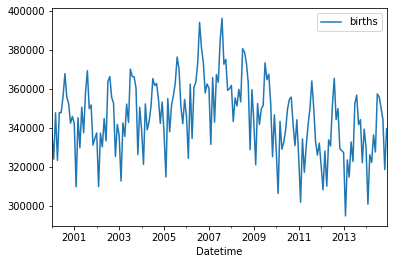

In [9]:
cols=['births','Datetime']
births=df[cols]
births=births.set_index('Datetime')
births_monthly = births.resample('M').sum()
births_monthly.plot()

In [10]:
births_monthly.shape

(180, 1)

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=births_monthly, model='additive', period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

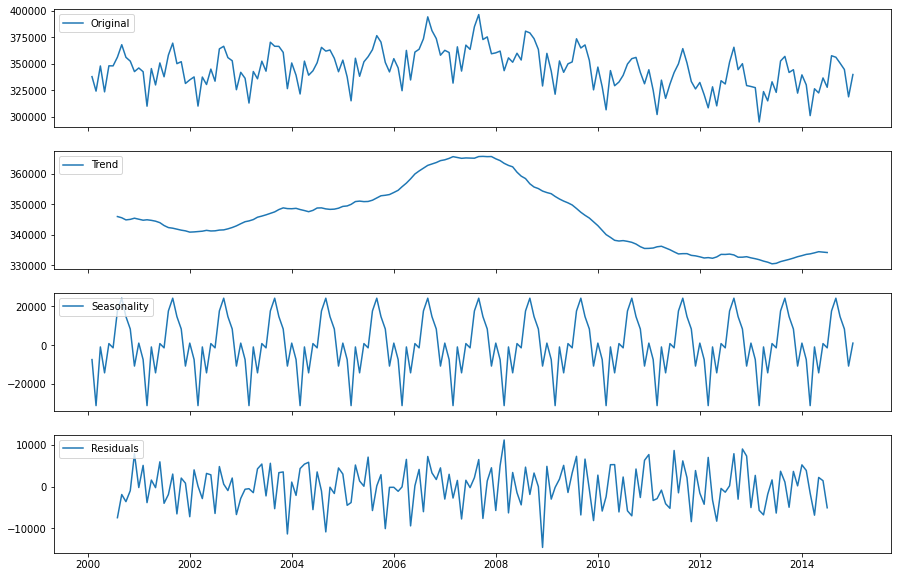

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(births_monthly, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [13]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(births_monthly)

In [14]:
pvalue

0.6532972060707174

### PValue is higher thant let us say 5% of confidence level, so we cannot reject the null hypthesis that this data is nonstationary. We will have to stationarize the series

In [15]:
births_monthly['lag1'] = births_monthly['births'].shift(-1)

In [16]:
births_monthly['difference']=births_monthly['births']-births_monthly['lag1']
births_monthly.head()

,births,lag1,difference
Datetime,,,
2000-01-31,337739,324046.0,13693.0
2000-02-29,324046,347824.0,-23778.0
2000-03-31,347824,323357.0,24467.0
2000-04-30,323357,347950.0,-24593.0
2000-05-31,347950,347899.0,51.0


In [17]:
births_monthly[:179]

,births,lag1,difference
Datetime,,,
2000-01-31,337739,324046.0,13693.0
2000-02-29,324046,347824.0,-23778.0
2000-03-31,347824,323357.0,24467.0
2000-04-30,323357,347950.0,-24593.0
2000-05-31,347950,347899.0,51.0
...,...,...,...
2014-07-31,357476,356066.0,1410.0
2014-08-31,356066,350497.0,5569.0
2014-09-30,350497,344471.0,6026.0


<AxesSubplot:xlabel='Datetime'>

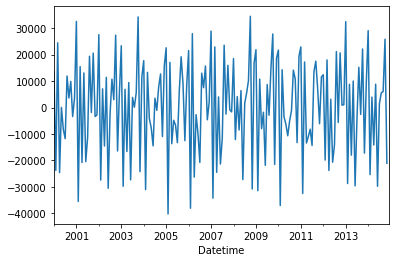

In [18]:
births_monthly['difference'].plot()

In [19]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(births_monthly['difference'][:179])

In [20]:
pvalue 

0.049831700817581676

### Now we have turned the series into stationary, we can try a SARIMA model with difference 1

## 4. Summary of training at least three variations of the Time Series, Survival Analysis, or Deep Learning model you selected. For example, you can use different models or different hyperparameters.

The three variations used were:
* **"Intuitive" SARIMA**: with difference order one and P:2 and Q:3 based on the Autocorrelation and Partial Autocorrelation plots
* **SARIMA model based on AIC optimization**: it was used pmdarima with three different difference order variants in arima as well as the seasonal component and the model with less AIC turned out to be:
      auto-fit order: : (0, 0, 1)
      auto-fit seasonal_order: : (0, 1, 0, 12)
      AIC was reduced from 3952 to 3523.
* Tried **Prophet model** to check if the prediction could be improved but negative values were predicted and mape was higher than SARIMAs models so it was discarded.
    
Both SARIMAs models had a good behaviour of residuals considering the diagnostics plots and the summary showed that all coefficients were relevant with Pvalues in zero.

In [ ]:
ts_births=births_monthly.drop(['difference','lag1'],axis=1)

In [22]:
import statsmodels.api as sm
import seaborn as sns
from colorsetup import colors, palette
sns.set_palette(palette)
import warnings
warnings.simplefilter(action='ignore')

In [23]:
def plots(data, lags=None):
    fig = plt.figure(figsize=(20,5))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

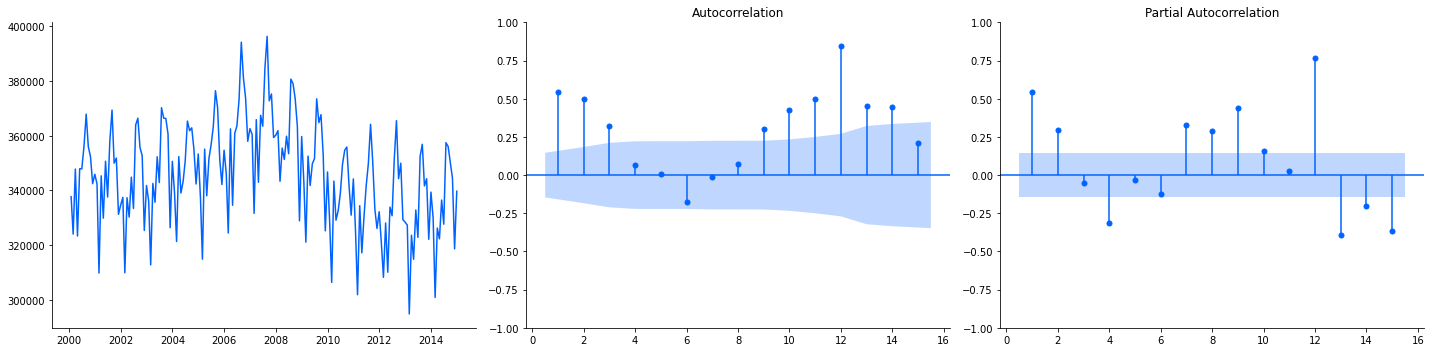

In [24]:
plots(ts_births.births, lags=15)

In [25]:
sar = sm.tsa.statespace.SARIMAX(ts_births.births, 
                                order=(2,1,3), 
                                seasonal_order=(1,0,0,12), 
                                trend='c',freq='M').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              births   No. Observations:                  180
Model:             SARIMAX(2, 1, 3)x(1, 0, [], 12)   Log Likelihood               -1968.012
Date:                             Sat, 25 Jun 2022   AIC                           3952.025
Time:                                     11:38:38   BIC                           3977.524
Sample:                                 01-31-2000   HQIC                          3962.364
                                      - 12-31-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -288.7339   3754.207     -0.077      0.939   -7646.843    7069.376
ar.L1         -1.6837      0.038    -44.063      0.000      -1.759      -1.609
ar.L2         -0.9506      0.037    -26.025      0.000      -1.022      -0.879
ma.L1          1.5523      0.044     35.260      0.000       1.466       1.639
ma.L2          0.7642      0.044     17.180      0.000       0.677       0.851
ma.L3         -0.1064      0.031     -3.378      0.001      -0.168      -0.045
ar.S.L12       0.1783      0.016     11.311      0.000       0.147       0.209
sigma2      2.048e+08      0.029   6.98e+09      0.000    2.05e+08    2.05e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.57   Jarque-Bera (JB):                27.38
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.46
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.71e+25. Standard errors may be unstable.
"""

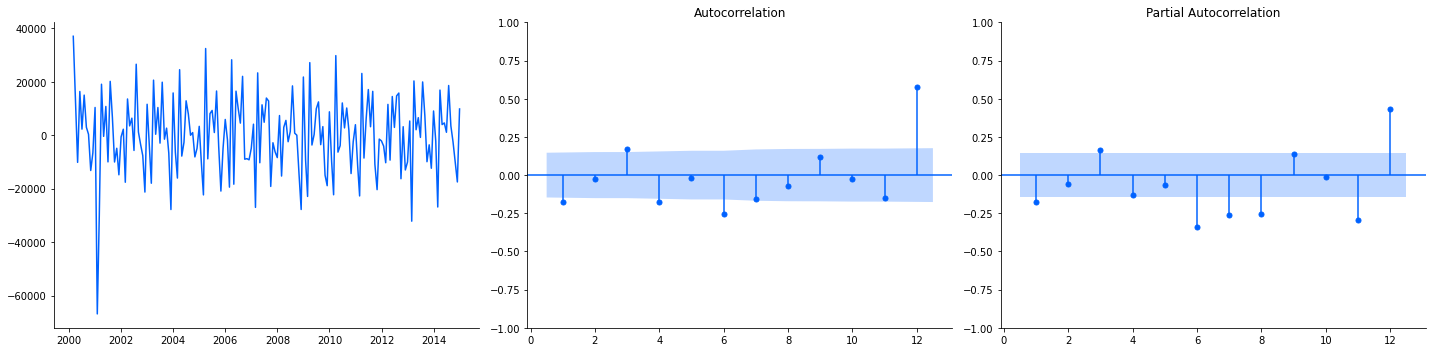

In [26]:
# plot resids
plots(sar.resid[sar.loglikelihood_burn:], lags=12)

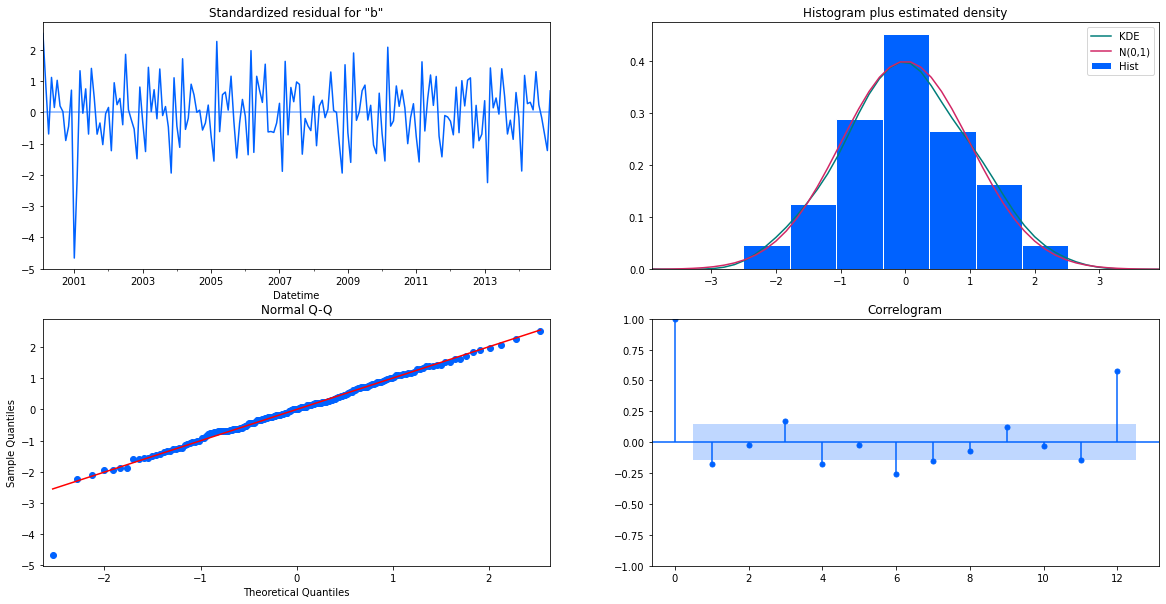

In [27]:
# plot residual diagnostics
sar.plot_diagnostics(lags=12,figsize = (20,10),);

In [34]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib

sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm

In [35]:
stepwise_model = pm.auto_arima(births_monthly.births, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=3544.733, BIC=3560.353, Fit time=0.774 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=3526.671, BIC=3532.919, Fit time=0.025 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=3525.291, BIC=3537.787, Fit time=0.250 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=3523.140, BIC=3535.636, Fit time=0.221 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=3525.137, BIC=3540.757, Fit time=0.514 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=3523.106, BIC=3532.478, Fit time=0.072 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=3545.752, BIC=3558.248, Fit time=0.204 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 1, 0, 12); AIC=3523.557, BIC=3536.053, Fit time=0.105 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 0, 12); AIC=3530.928, BIC=3546.548, Fit time=0.180 seconds
Fit ARIMA: order=(0, 0, 1) s

In [36]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_months):
    pred_first = series.index.max()+relativedelta(months=1)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

In [39]:
stepwise_model2 = pm.auto_arima(births_monthly.births, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model2.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=3972.682, BIC=3988.619, Fit time=0.297 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=4012.988, BIC=4019.363, Fit time=0.017 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=3964.625, BIC=3977.375, Fit time=0.161 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=3973.321, BIC=3986.070, Fit time=0.179 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=3998.371, BIC=4007.933, Fit time=0.040 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 12); AIC=3957.731, BIC=3973.668, Fit time=0.390 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=3947.903, BIC=3967.027, Fit time=0.551 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=3962.247, BIC=3978.184, Fit time=0.328 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=3948.592, BIC=3970.904, Fit time=0.687 seconds
Fit ARIMA: order=(1, 1, 1) s

In [40]:
stepwise_model3 = pm.auto_arima(births_monthly.births, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model3.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3534.708, BIC=3550.298, Fit time=1.427 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3531.728, BIC=3537.964, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3545.735, BIC=3558.207, Fit time=0.204 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3547.878, BIC=3560.350, Fit time=0.295 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3533.489, BIC=3542.843, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3533.482, BIC=3542.836, Fit time=0.166 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3524.727, BIC=3537.199, Fit time=0.670 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3528.589, BIC=3544.179, Fit time=1.026 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3529.612, BIC=3545.202, Fit time=1.085 seconds
Fit ARIMA: order=(1, 1, 1) s

In [42]:
print('auto-fit order: :', stepwise_model.order)
print('auto-fit seasonal_order: :', stepwise_model.seasonal_order)

auto-fit order: : (0, 0, 1)
auto-fit seasonal_order: : (0, 1, 0, 12)


In [43]:
sar_newparams = sm.tsa.statespace.SARIMAX(ts_births.births, 
                                order=(0,0,1), 
                                seasonal_order=(0,1,0,12), 
                                trend='c',freq='M').fit()
sar_newparams.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              births   No. Observations:                  180
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood               -1758.553
Date:                             Sat, 25 Jun 2022   AIC                           3523.106
Time:                                     12:03:46   BIC                           3532.478
Sample:                                 01-31-2000   HQIC                          3526.909
                                      - 12-31-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -729.9986    713.370     -1.023      0.306   -2128.179     668.182
ma.L1          0.0616      0.016      3.777      0.000       0.030       0.094
sigma2      7.384e+07      0.012   5.93e+09      0.000    7.38e+07    7.38e+07
===================================================================================
Ljung-Box (L1) (Q):                  22.96   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.00   Prob(JB):                         0.42
Heteroskedasticity (H):               1.18   Skew:                            -0.23
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.39e+24. Standard errors may be unstable.
"""

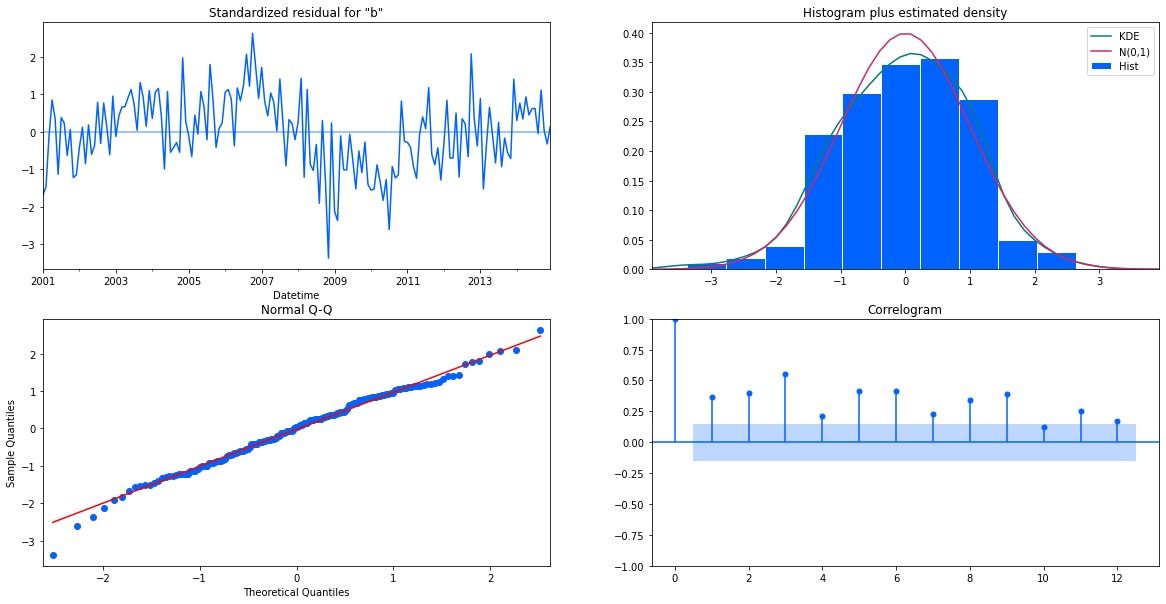

In [44]:
sar_newparams.plot_diagnostics(lags=12,figsize = (20,10),);

In [53]:
def cross_validate(series,horizon,start,step_size,order,seasonal_order,trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [76]:
series = births_monthly.births
horizon = 12
start = 120
step_size = 1
order = (0,0,1)
seasonal_order = (0,1,0,12)

cv_pm = cross_validate(births_monthly.births,12,120,1,
                    order = order,
                    seasonal_order = seasonal_order)

In [77]:
model_cvpm = sm.tsa.statespace.SARIMAX(series[:121], 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=None).fit()

In [78]:
cv_pm.head()

,fcst,actual
2011-01-31,328120.0,324845
2011-02-28,306393.0,301927
2011-03-31,343448.0,334439
2011-04-30,329137.0,317225
2011-05-31,332651.0,330667


<AxesSubplot:title={'center':'Forecast vs Actual SARIMA optimized'}>

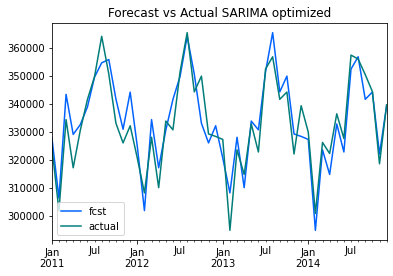

In [142]:
cv_pm.plot(title = 'Forecast vs Actual SARIMA optimized')

In [80]:
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

In [81]:
mape(cv_pm)

0.016575217871582316

In [82]:
series = births_monthly.births
horizon = 12
start = 120
step_size = 1
order = (2,1,3)
seasonal_order = (1,0,0,12)

cv_intuit = cross_validate(births_monthly.births,12,120,1,
                    order = order,
                    seasonal_order = seasonal_order)

<AxesSubplot:title={'center':'Forecast vs Actual "Intuitive SARIMA"'}>

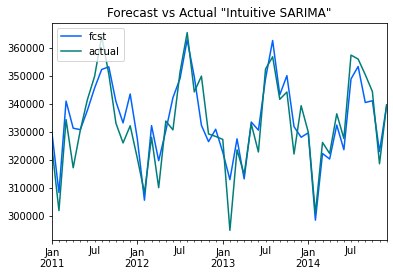

In [143]:
cv_intuit.plot(title = 'Forecast vs Actual "Intuitive SARIMA"')

In [84]:
mape(cv_intuit)

0.017053833501564166

In [85]:
import fbprophet
from fbprophet import Prophet

In [91]:
df_prophet=births_monthly.reset_index()
df_prophet['ds']=df_prophet['Datetime']
df_prophet['y']=df_prophet['births']
cols=['lag1','difference','Datetime','births']
df_prophet=df_prophet.drop(cols,axis=1)
df_prophet.head()

,ds,y
0,2000-01-31,337739
1,2000-02-29,324046
2,2000-03-31,347824
3,2000-04-30,323357
4,2000-05-31,347950


In [92]:
m = Prophet()
m.fit(df_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [93]:
future = m.make_future_dataframe(periods=12)
print(future.head())
print(future.tail())

          ds
0 2000-01-31
1 2000-02-29
2 2000-03-31
3 2000-04-30
4 2000-05-31
            ds
187 2015-01-08
188 2015-01-09
189 2015-01-10
190 2015-01-11
191 2015-01-12


In [94]:
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
187,2015-01-08,325346.435516,319310.040056,331693.965460
188,2015-01-09,325623.486108,318815.892254,331721.454264
189,2015-01-10,326251.660507,319794.611014,332383.097448
190,2015-01-11,327208.884099,320682.923403,333919.859116
191,2015-01-12,328462.032285,322198.909945,335249.280856


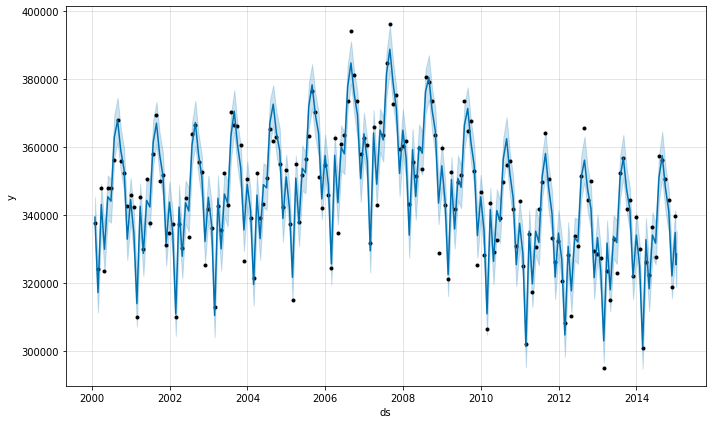

In [95]:
m.plot(forecast);

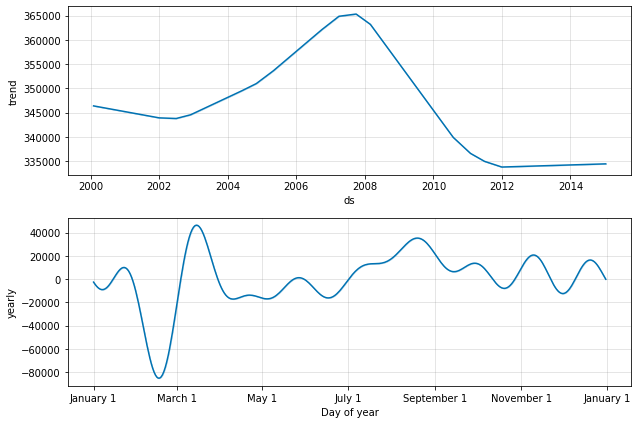

In [96]:
m.plot_components(forecast);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


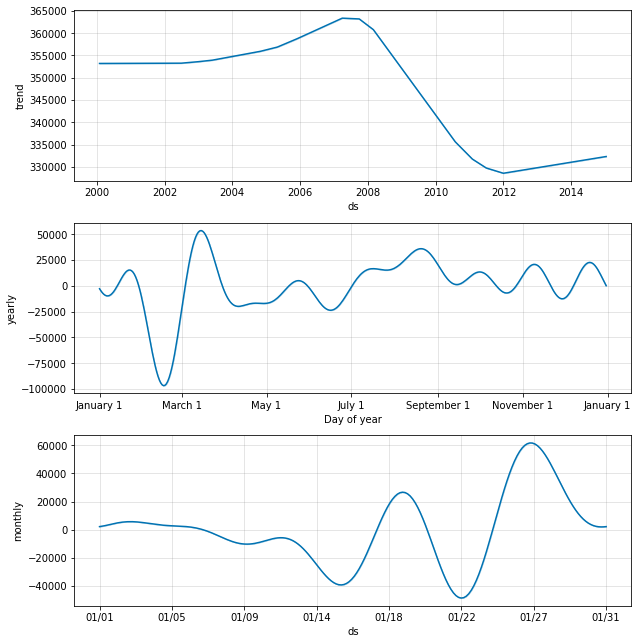

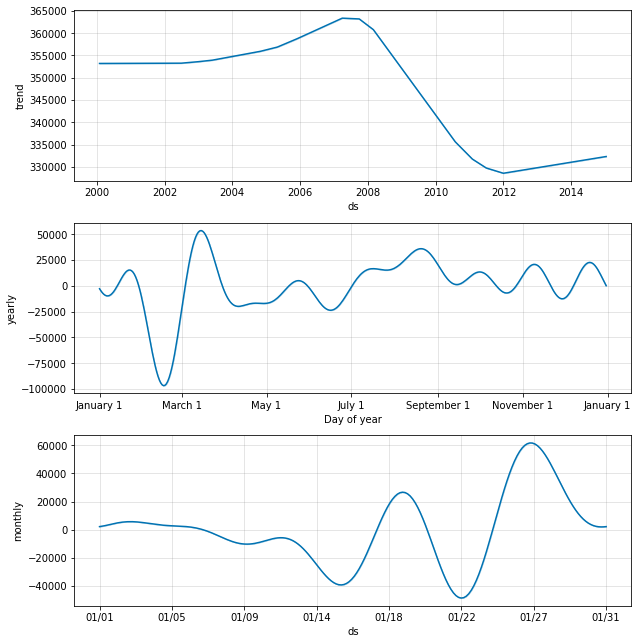

In [98]:
ms = Prophet()
ms.add_seasonality(name='monthly', period=30.5, fourier_order=5)
ms.fit(df_prophet)
forecast = ms.predict(future)
ms.plot_components(forecast)

In [99]:
train_df=df_prophet[120:168]

In [101]:
train_df.tail()

,ds,y
163,2013-08-31,356879
164,2013-09-30,341676
165,2013-10-31,344285
166,2013-11-30,322157
167,2013-12-31,339399


In [103]:
test_df=df_prophet[168:]

In [106]:
y_true=test_df['y']

In [107]:
prophet_m=Prophet()
prophet_m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet_m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [108]:
future = prophet_m.make_future_dataframe(periods=12)
forecast = prophet_m.predict(future)

In [113]:
y_true=df_prophet[120:]['y'].values
y_pred=forecast['yhat'].values

In [117]:
from sklearn.metrics import mean_absolute_percentage_error
mape_prophet = mean_absolute_percentage_error(y_true, y_pred)

In [118]:
print(mape_prophet)

0.12965764603203964


In [123]:
train_df.head()

,ds,y
120,2010-01-31,328120
121,2010-02-28,306393
122,2010-03-31,343448
123,2010-04-30,329137
124,2010-05-31,332651


<AxesSubplot:>

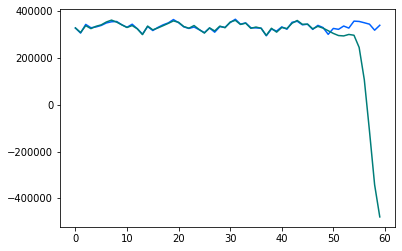

In [140]:
pd.Series(y_true).plot()
pd.Series(y_pred).plot()

## 5. A paragraph explaining which of your models you recommend as a final model that best fits your needs in terms of accuracy or explainability.

Given that Prophet was discarded the decision is between the SARIMAs models. It was trained data from 2011 to 2013 to predict 2014, and mapes were very simialr (0.016 for optimized SARIMA and 0.017 for intuitive SARIMA)
I think that the best model would be Intuitive SARIMA, since optimized SARIMA having difference order zero, shows certain patterns on the residuals and Jarque Bera test has Pvalue higher that 5%.


## 6. Summary Key Findings and Insights, which walks your reader through the main findings of your modeling exercise.


* Our time series has trend and seasonality so these factors have to be considered in our model
* The model chosen was SARIMA with p,d,q = 2,1,3 with the addition of seasonality.
* According to the summary all coefficients (except for the intercept) were statistically significant and diagnostics of residuals look like expected with mean around zero.

## 7. Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model or adding specific data features to achieve a better model.

* It could be tried if using daily data would make Prophet improve its predictions. I have read that since the model is based on continuous data it does not make a good job with monthly predictions.
* Another possibility to try, would be to get 2015 monthly births to check how well our predictions would do based on training our full dataset.